In [1]:

import matplotlib.pyplot as plt
import yaml
with open('frozen_stats/stats', 'r') as f:
    data_full = yaml.load(f.read())

In [6]:
colors = [
'#d6604d',
'#4393c3',
'red',
'blue'
]

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse

def filter(keywords):
    assert isinstance(keywords, list)
    temp = [i for i in data_full if all(keyword in i['video_name'] for keyword in keywords)]
    return temp[-1]

def filters(keywords):
    assert isinstance(keywords, list)
    temp = [i for i in data_full if all(keyword in i['video_name'] for keyword in keywords)]
    return temp

def transform(data_list):
    return [i['bw'] / i['gt_bw'] for i in data_list], [i['f1'] for i in data_list]

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = f'{filename}_time_{timestr}.pdf'
    fig.savefig(filename, bbox_inches='tight')

def add_data(ax, data, color):

    # print(data[1])
    cov = np.cov(data[0], data[1])
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_) / math.sqrt(len(data[0]))
    
    print(np.mean(data[1]))

    ell = Ellipse(xy=(np.mean(data[0]), np.mean(data[1])),
            width=lambda_[0]*2,
            height=lambda_[1]*2,
            angle=np.rad2deg(np.arccos(v[0,0])),
            alpha=0.9)
    ell.set_edgecolor(color)
    ell.set_facecolor(color)
    ax.add_artist(ell)
    #plt.scatter(data[0], data[1], c = color)
    ax.scatter([np.mean(data[0])], [np.mean(data[1])], marker = 'o', color = 'black', s=10,zorder=3)


In [4]:
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

0.7472340404987335
0.7777071356773376
0.8005468726158143
0.8803070306777954


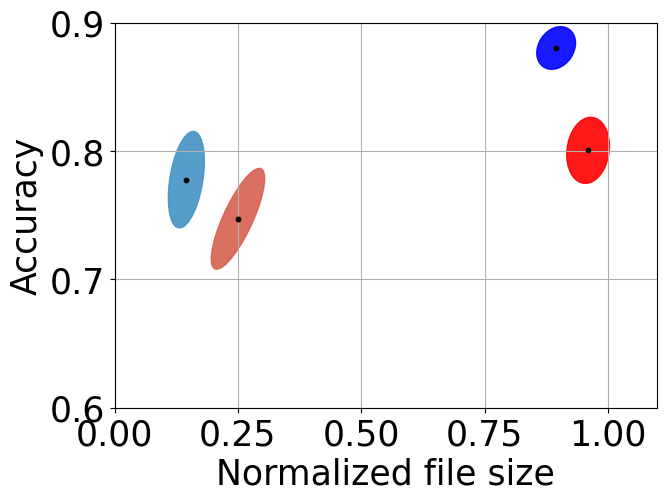

In [15]:

# plot dashcam

ids = [(i+1) for i in range(10)]
accs = [filter([f'dashcam/dashcam_{i}_', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'dashcam/dashcam_{i}_qp_'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)

plt.style.use('default')
plt.rcParams['font.size']=25
plt.rcParams['pdf.fonttype'] = 42

fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

add_data(ax, mpegs, colors[0])
add_data(ax, accs, colors[1])
add_data(ax, ddss, colors[2])
add_data(ax, eaars, colors[3])
ax.set_xlim(0, 1.1)
ax.set_ylim(0.6, 0.9)
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/detection_dashcam', fig)




0.7687479257583618
0.7980058073997498
0.6528869271278381
0.7999021649360657


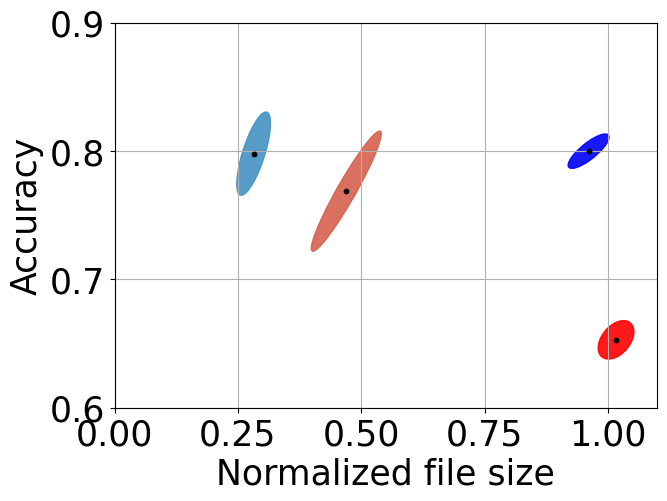

In [16]:

# plot drone

ids = [169, 170, 171, 172, 173]
accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
ddss = [filter([f'visdrone/videos/vis_{i}', 'dds']) for i in ids]
eaars = [filter([f'visdrone/videos/vis_{i}', 'eaar']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'visdrone/videos/vis_{i}_qp'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)

plt.style.use('default')
plt.rcParams['font.size']=25
plt.rcParams['pdf.fonttype'] = 42

fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

add_data(ax, mpegs, colors[0])
add_data(ax, accs, colors[1])
add_data(ax, ddss, colors[2])
add_data(ax, eaars, colors[3])
ax.set_xlim(0, 1.1)
ax.set_ylim(0.6, 0.9)
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/detection_vis', fig)




In [94]:
# plot delay`
import re
pattern = re.compile('for ([0-9\.]*)')


with open('frozen_stats/blackgen.cpu', 'r') as f:
    cpu = [float(i) for i in pattern.findall(f.read())]
with open('frozen_stats/blackgen.gpu', 'r') as f:
    gpu = [float(i) for i in pattern.findall(f.read())]

mp4 = 1/55
mp5 = 1/35
webm = 1/14


In [96]:
np.mean(cpu)

1.6336586902390664